# CS4277/CS5477 Lab 4: Plane Sweep Stereo

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport lab4

import math
import json

import cv2
import k3d
import matplotlib.pyplot as plt
import numpy as np

from lab4 import *

np.set_printoptions(precision=3)  # Print less digits

### Introduction
In this assignment, you will compute a dense 3D model from multi-view stereo, i.e. the plane sweeping algorithm. 

This assignment is worth **20%** of the final grade.

References:
* Lecture 3
* Lecture 10

Optional references:
* A space-sweep approach to true multi-image matching \[[link](https://www.ri.cmu.edu/pub_files/pub1/collins_robert_1996_1/collins_robert_1996_1.pdf)\]

### Instructions
This workbook provides the instructions for the assignment, and facilitates the running of your code and visualization of the results. For each part of the assignment, you are required to **complete the implementations of certain functions in the accompanying python file** (`lab4.py`).

To facilitate implementation and grading, all your work is to be done in that file, and **you only have to submit the .py file**.

Please note the following:
1. Fill in your name, email, and NUSNET ID at the top of the python file.
2. The parts you need to implement are clearly marked with the following:

    ```
    """ YOUR CODE STARTS HERE """

    """ YOUR CODE ENDS HERE """
    ```
    
    , and you should write your code in between the above two lines.
3. Note that for each part, there may certain functions that are prohibited to be used. It is important **NOT to use those prohibited functions** (or other functions with similar functionality). If you are unsure whether a particular function is allowed, feel free to ask any of the TAs.


### Submission Instructions
Upload your completed `lab4.py` onto the relevant work bin in Luminus.

---
## Part 1: Computation of Relative Extrinsics, Plane Sweep Homography
In this part, you will first create helper modules for plane sweep stereo. As we have discussed in the lectures, two cameras observing a plane are related by a homography. In this part, you will compute the homography that relates two given camera views.

Below, we provide the camera intrinsic matrix, as well as the camera poses for two cameras. To simplify the problem, both cameras share the same intrinsic matrix $K$. The camera poses are given as a $3 \times 4$ matrix $\mathbf{M}=[\mathbf{R} | \mathbf{t}]$ (consisting of a rotation matrix $\mathbf{R}$ and a translation vector $\mathbf{t}$)  that transforms points in the world frame $(X_w, Y_w, Z_w)$ to the input camera frame $(X_c, Y_c, Z_c)$, i.e.
$$
\begin{bmatrix}
X_i \\
Y_i \\
Z_i
\end{bmatrix}
=
\mathbf{M}
\begin{bmatrix}
X_w \\
Y_w \\
Z_w \\
1
\end{bmatrix}
$$


In [2]:
# Intrinsic matrix
K = np.array([[615.,   0., 320.],
              [  0., 615., 240.],
              [  0.,   0.,   1.]])

M_ref = np.array([[ 3.93242408e-01, 7.74463219e-05,  9.19434828e-01, -1.44320811e+00],
                  [ 1.51103741e-01, 9.86397614e-01, -6.47101783e-02,  1.79934373e-01],
                  [-9.06933332e-01, 1.64376828e-01,  3.87881670e-01,  1.12435457e+00]])
M_i = np.array([[ 5.78006380e-01, -4.51644884e-05,  8.16032243e-01, -1.43107499e+00],
                [ 1.09801992e-01,  9.90910301e-01, -7.77193532e-02,  1.43357565e-01],
                [-8.08611246e-01,  1.34524248e-01,  5.72757435e-01,  8.10162936e-01]])

In [3]:
# not sure how to not use np.linalg.inv() to do this

def compute_relative_pose(cam_pose, ref_pose):
    """Compute relative pose between two cameras

     Args:
        cam_pose (np.ndarray): Extrinsic matrix of camera of interest C_i (3,4).
          Transforms points in world frame to camera frame, i.e.
            x_i = C_i @ x_w  (taking into account homogeneous dimensions)
        ref_pose (np.ndarray): Extrinsic matrix of reference camera C_r (3,4)

    Returns:
        relative_pose (np.ndarray): Relative pose of size (3,4). Should transform 
          points in C_r to C_i, i.e. x_i = M @ x_r

    Prohibited functions:
        Do NOT use np.linalg.inv() or similar functions
    """
    relative_pose = np.zeros((3, 4), dtype=np.float64)

    """ YOUR CODE STARTS HERE """
    
    Ri = cam_pose[:, 0:3]
    ti = cam_pose[:, -1]
    
    Rref = ref_pose[:, 0:3]
    tref = ref_pose[:, -1]
    
    rel_rotation = np.zeros((3,3))
    rel_translation = np.zeros((3,1))
    
    rel_rotation = Ri.dot(Rref.T)
    rel_translation = ti - Ri.dot(Rref.T).dot(tref)
    
    relative_pose[:, 0:3] = rel_rotation
    relative_pose[:, -1] = rel_translation

    """ YOUR CODE ENDS HERE """
    return relative_pose

Before we can compute the plane sweep homographies between two cameras, we need to first compute the relative poses (i.e. extrinsic matrices) between two cameras. Given the pose of camera of interest $\mathbf{M}_i$ and the reference camera pose $\mathbf{M}_{ref}$, compute the relative pose between the two cameras which transforms points in the reference frame the frame of the camera of interest.

**Implement the following functions(s): compute_relative_pose()**
* <u>Prohibited Functions</u>: `np.linalg.inv()`

Once you have the relative pose, you can now compute the homographies that relate the images in the two cameras for given (inverse) depths. To simplify the problem, assume that the planes are fronto-parallel with respect to the reference camera. For $D$ inverse depth values, your function should output a matrix of size $(D, 3, 3)$.

**Implement the following functions(s): get_plane_sweep_homographies()**.

Note that the depths are provided as *inverse* depths $1/d$.

In [62]:
# inv_depths = np.array([0.1, 0.06944444, 0.03888889, 0.00833333])
# size = len(inv_depths)
# for i in range(size):
#     print(i)

# # matrix = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
# # print(3 * matrix)

# # # one = matrix[:, 0:3]
# # # two = matrix[:, -1]

# # # # print(one.shape)
# # # # print(two.shape)

# # # print(one.T)

nm = np.array([0, 0, 1])
print(nm)
print(nm.shape)
# size = 2
# arr = np.zeros((size,3,3))
# print(arr)

arr1 = np.array([[1,2,3], [4,5,6], [7,8,9]])
arr2 = np.array([10, 11, 12])

# joined = np.zeros((3,4))
# joined[:, 0:3] = arr1
# joined[:, -1] = arr2
# print(joined)

nmt = nm.T
print(nmt)
nmt.reshape(1,3)
print(nmt.shape)

[0 0 1]
(3,)
[0 0 1]
(3,)


In [4]:
def compute_homography(K, relative_pose, inv_depth):
    relative_rotation = relative_pose[:, 0:3]
    relative_translation = relative_pose[:, -1]
    nmT = np.array([0, 0, 1])
    return K.dot(relative_rotation.T + inv_depth * relative_rotation.T.dot(relative_translation).dot(nmT)).dot(np.linalg.inv(K))

In [5]:
def get_plane_sweep_homographies(K, relative_pose, inv_depths):
    """Compute plane sweep homographies, assuming fronto parallel planes w.r.t.
    reference camera

    Args:
        K (np.ndarray): Camera intrinsic matrix (3,3)
        relative_pose (np.ndarray): Relative pose between the two cameras
          of shape (3, 4)
        inv_depths (np.ndarray): Inverse depths to warp of size (D, )

    Returns:
        homographies (D, 3, 3)
    """

    homographies = None

    """ YOUR CODE STARTS HERE """
    size = len(inv_depths)
    homographies = np.zeros((size, 3, 3))
    
    for i in range(size):
        homographies[i] = compute_homography(K, relative_pose, inv_depths[i])
        
    
    """ YOUR CODE ENDS HERE """

    return homographies

In [6]:
# (uncomment to get from file) from lab4 import get_plane_sweep_homographies, compute_relative_pose

# Inverse depths
inv_depths = np.array([0.1, 0.06944444, 0.03888889, 0.00833333])
relative_pose = compute_relative_pose(M_i, M_ref)
print("relative pose") # right
print(relative_pose)
homographies = get_plane_sweep_homographies(K, relative_pose, inv_depths)
print("homographies:") # wrong currently
lala = homographies
lala[0] = lala[0] / 8.649e-01 * 1.086e+00
print(homographies)

relative pose
[[ 0.978  0.034 -0.208  0.207]
 [-0.028  0.999  0.033 -0.114]
 [ 0.209 -0.027  0.978  0.017]]
homographies:
[[[ 1.086e+00 -1.954e-02  2.075e+02]
  [-6.376e-02  1.265e+00 -1.244e+01]
  [-4.302e-04  6.150e-05  1.347e+00]]

 [[ 8.663e-01 -1.415e-02  1.654e+02]
  [-4.949e-02  1.009e+00 -9.837e+00]
  [-3.411e-04  5.048e-05  1.073e+00]]

 [[ 8.677e-01 -1.274e-02  1.654e+02]
  [-4.820e-02  1.010e+00 -9.766e+00]
  [-3.396e-04  5.199e-05  1.073e+00]]

 [[ 8.691e-01 -1.134e-02  1.655e+02]
  [-4.691e-02  1.012e+00 -9.695e+00]
  [-3.381e-04  5.350e-05  1.073e+00]]]


If implemented correctly, the above should print:
```
[[[ 1.086e+00  2.067e-02 -1.541e+02]
  [ 5.322e-02  9.887e-01 -5.925e+00]
  [ 3.393e-04 -4.318e-05  8.811e-01]]

 [[ 1.086e+00  2.067e-02 -1.582e+02]
  [ 5.322e-02  9.887e-01 -3.899e+00]
  [ 3.393e-04 -4.318e-05  8.806e-01]]

 [[ 1.086e+00  2.067e-02 -1.623e+02]
  [ 5.322e-02  9.887e-01 -1.873e+00]
  [ 3.393e-04 -4.318e-05  8.801e-01]]

 [[ 1.086e+00  2.067e-02 -1.663e+02]
  [ 5.322e-02  9.887e-01  1.527e-01]
  [ 3.393e-04 -4.318e-05  8.796e-01]]]
```

---
## Part 2: Plane Sweep Stereo
In this part, you will write the code for performing the plane sweep stereo. We will perform plane sweeps on images from the [Tsukuba](https://home.cvlab.cs.tsukuba.ac.jp/dataset) dataset. 

The dataset we will work on contains $n=10$ images. We will use one of these as the reference camera view, and warp all images to this view. Let us first load the dataset and visualize the images.

Loading data from data/tsukuba...
Loaded data containing 10 images.
Reference camera pose:
 [[ 3.932e-01  7.745e-05  9.194e-01 -1.443e+00]
 [ 1.511e-01  9.864e-01 -6.471e-02  1.799e-01]
 [-9.069e-01  1.644e-01  3.879e-01  1.124e+00]]


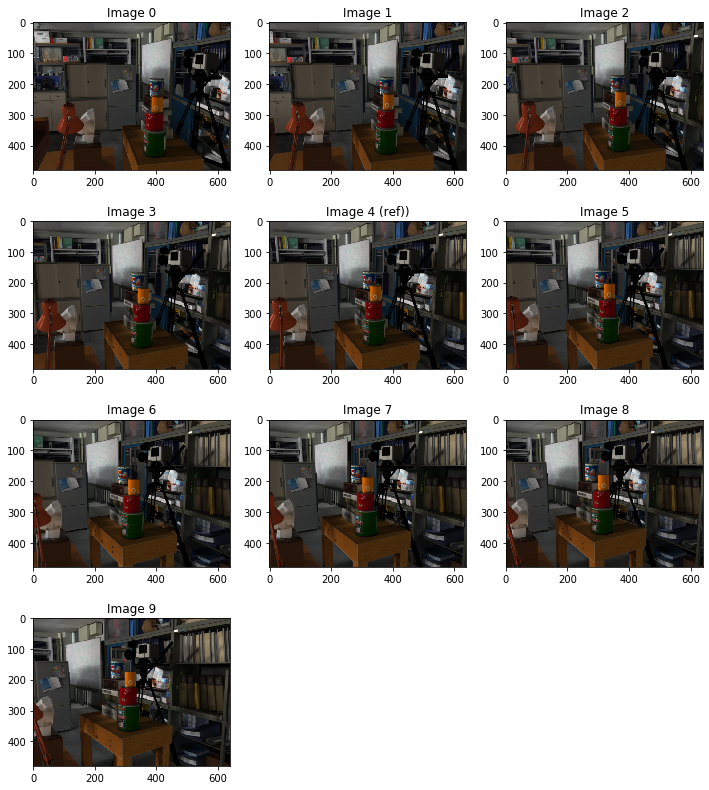

In [7]:
from lab4 import load_data

ref_id = 4  # use image 4 as the reference view
data_folder = 'data/tsukuba'
images, K, (img_height, img_width) = load_data(data_folder)
ref_pose = images[ref_id].pose_mat
print('Reference camera pose:\n', ref_pose)

# Visualizes the source images
plt.figure(figsize=(12, 14))
num_rows = math.ceil(len(images) / 3)
plt.tight_layout()
for i in range(len(images)):
    plt.subplot(num_rows, 3, i+1)
    plt.imshow(images[i].image)
    if i == ref_id:
        plt.title('Image {} (ref))'.format(i))
    else:
        plt.title('Image {}'.format(i))

The images are stored as instances of our `Image` class. You can see its implementation in `lab4.py`, but otherwise you should only need to access the following member variables:
- `pose_mat`: 3x4 transform $M$ to transform points from world to camera frame, i.e. $p_c = M \cdot p_w$
- `image`: The image bitmap itself

Now, the task is to implement the function to compute the plane sweep volume. The steps to do so are as follows:
1. Compute the relative pose between each image and the reference view
2. For every fronto-parallel plane at depth d,
   - Compute the homography transforms to warp each of the images to this reference view
   - Warp the images
3. Compute the variance at every pixel and depth. Compute the variance for each of the RGB channels separately, then take the average.

Note that not every image will cover every pixel of the reference view at all depths. You need to take this into account when computing the variance (i.e. the variance may be computed on less than $n$ images).

After computing the plane sweep volume, the depths can be obtained as the depth that results in the minimum variance.

**Implement the following functions(s): compute_plane_sweep_volume(), compute_depths()**

Your function should output two required and one optional variables:
1. `ps_volume`: Plane sweep volume of size $(D, H, W)$
2. `accum_count`: Number of valid images considered in computing the variance for each pixel, with size $(D, H, W)$
3. `extras` (optional): Any extra information you might want to use for part 4 of the assignment.

*Hint: You might find the following functions useful: `get_plane_sweep_homographies()` (from Part 1), and `cv2.warpPerspective()`.*

Note that plane sweep stereo is very computation heavy. **A portion of the score for this part will be based on how fast your code runs.**

In [173]:
# # need to call warpPerspective a second time 
# # using same homography matrix with a white image


# im = np.full((2,2,3), 255)

# # Visualizes the source images
# plt.figure(figsize=(12, 14))
# plt.tight_layout()
# plt.imshow(im)

# arr = np.zeros(10)
# print(arr)

pixel = (1,2)
print(pixel[0])

print(pow(2,2))

if 1 == 2 or 2 == 3:
    print("true")
else:
    print("false")
    
print(img_height)
print(img_width)

1
4
false
480
640


In [8]:
def computeVariance(dests, mask, pixel, count):
    x = pixel[0]
    y = pixel[1]

    sumRGB = 0
    for i in range(3):
        sum = 0
        for j in range(len(mask)):
            if mask[j] == 1:
                sum += dests[j][x][y][i]
        mean = sum / count
        var = 0
        for j in range(len(mask)):
            if mask[j] == 1:
                var += pow(dests[j][x][y][i] - mean, 2)
        var /= (count - 1)
        sumRGB += var
        
    return sumRGB / 3

In [9]:
def compute_plane_sweep_volume(images, ref_pose, K, inv_depths, img_hw):
    D = len(inv_depths)
    H, W = img_hw
    ps_volume = np.zeros((D, H, W), dtype=np.float64)
    accum_count = np.zeros((D, H, W), dtype=np.int32)
    extras = []
    
    """ YOUR CODE STARTS HERE """
    white = np.full((H,W,3), 255, dtype=np.float64)
    rel_poses = []
    homographies = [] # for all images
    for i in range(len(images)):
        # Compute relative pose between images[i] and reference
        rel_poses.append(compute_relative_pose(images[i].pose_mat, ref_pose))
        
        # get homographies to warp reference onto image (for each d)
        homographies.append(get_plane_sweep_homographies(K, rel_poses[i], inv_depths)) # numImages x d x 3 x 3
    
    
    for j in range(len(inv_depths)):
        # compute all warped images at this depth
        # warp each image (src) onto reference view (dest)
        dests = []
        check = []
        for k in range(len(images)): 
            dests.append(cv2.warpPerspective(images[k].image, homographies[k][j], (W,H))) # numImages of images
            check.append(cv2.warpPerspective(white, homographies[k][j], (W,H))) # numImages of images
            
        for x in range(H):
            for y in range(W):
                pixel = (x,y)
                count = 0
                mask = np.zeros(len(images))
                for index in range(len(images)):
                    # if check == white, pixel is valid
                    if (check[index][x][y][0] == 255):
                        count += 1
                        mask[index] = 1
                if (count == 0 or count == 1):
                    ps_volume[j][x][y] = 0
                else:
                    ps_volume[j][x][y] = computeVariance(dests, mask, pixel, count)
                accum_count = count
                
    return ps_volume, accum_count, extras


In [ ]:
# Sweep D=256 planes from 0.8 to 6.0 meters away
num_depths = 256
inv_depths = np.linspace(1/0.8, 1/8.0, num=num_depths)

ps_volume, accum_count, extras = compute_plane_sweep_volume(images, ref_pose, K, inv_depths, 
                                                            (img_height, img_width))

In [196]:
# print(ps_volume)
print(accum_count) # 6
print(ps_volume)


6
[[[2.374e-06 1.523e-06 5.471e-06 ... 3.038e-02 3.045e-02 3.139e-02]
  [5.833e-06 3.388e-06 1.866e-05 ... 2.960e-02 3.046e-02 3.144e-02]
  [2.763e-05 1.951e-05 1.480e-05 ... 3.054e-02 3.112e-02 3.126e-02]
  ...
  [3.040e-03 3.233e-03 3.298e-03 ... 2.496e-02 2.362e-02 2.147e-02]
  [3.020e-03 3.157e-03 3.317e-03 ... 2.944e-02 2.895e-02 2.921e-02]
  [2.964e-03 3.047e-03 3.169e-03 ... 1.934e-03 1.936e-03 1.878e-03]]

 [[2.601e-06 1.307e-06 5.459e-06 ... 3.033e-02 3.054e-02 3.138e-02]
  [5.835e-06 3.405e-06 1.887e-05 ... 2.959e-02 3.042e-02 3.136e-02]
  [2.783e-05 1.971e-05 1.468e-05 ... 3.050e-02 3.106e-02 3.119e-02]
  ...
  [3.038e-03 3.234e-03 3.292e-03 ... 2.495e-02 2.349e-02 2.135e-02]
  [3.015e-03 3.151e-03 3.315e-03 ... 2.945e-02 2.891e-02 2.927e-02]
  [2.959e-03 3.045e-03 3.171e-03 ... 1.933e-03 1.936e-03 1.878e-03]]

 [[2.607e-06 1.011e-06 5.521e-06 ... 3.030e-02 3.049e-02 3.139e-02]
  [5.835e-06 3.478e-06 1.886e-05 ... 2.957e-02 3.041e-02 3.129e-02]
  [2.811e-05 1.980e-05 1.460e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640)
src
(480, 640, 3)
dest with src
(480, 640, 3)
dest with white
0.0
0.0
0.0
255.0
255.0
255.0


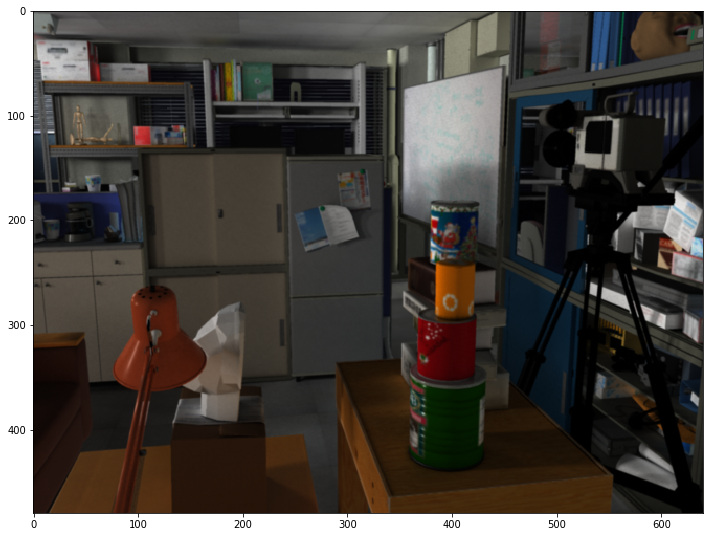

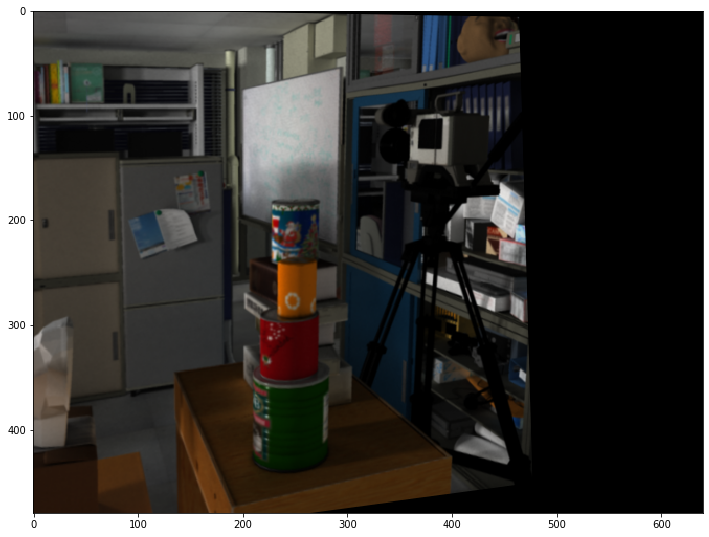

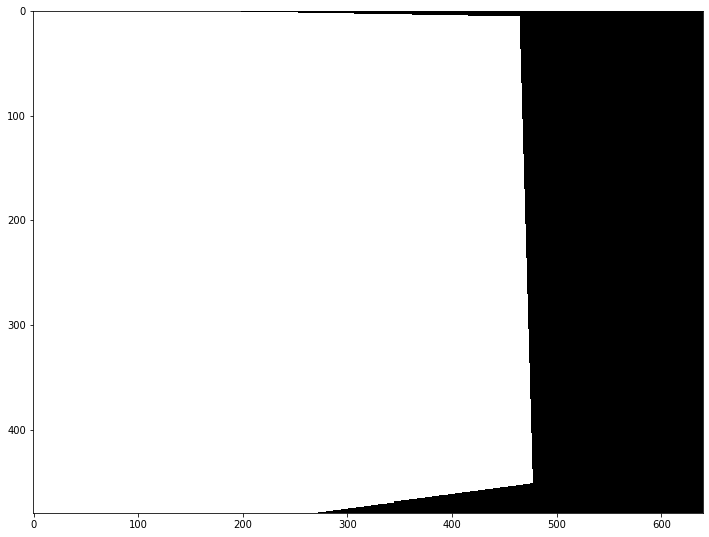

In [192]:
# # # testing
# print(img_hw)
# white = np.full((img_height,img_width,3), 255, dtype=np.float64)
# img_hw = (img_height, img_width)
# rel_pose = compute_relative_pose(images[0].pose_mat, ref_pose)
        
#         # get homographies to warp reference onto image (for each d)
# homo = get_plane_sweep_homographies(K, rel_pose, inv_depths) #  d x 3 x 3

# dest = cv2.warpPerspective(images[0].image, homo[0], (img_width, img_height))
# check = cv2.warpPerspective(white, homo[0], (img_width, img_height))
# print("src")
# print(images[0].image.shape)
# plt.figure(figsize=(12, 14))
# plt.tight_layout()
# plt.imshow(images[0].image)

# print("dest with src")
# print(dest.shape)
# plt.figure(figsize=(12, 14))
# plt.tight_layout()
# plt.imshow(dest)

# print("dest with white")
# plt.figure(figsize=(12, 14))
# plt.tight_layout()
# plt.imshow(check)

# # # if destination not white, dont use
# # print(check.shape)
# # print(check[639][479][0])
# # print(check[639][479][1])
# # print(check[639][479][2])

# print(check[479][639][0])
# print(check[479][639][1])
# print(check[479][639][2])

# print(check[0][0][0])
# print(check[0][0][1])
# print(check[0][0][2])


In [ ]:
def compute_depths(ps_volume, inv_depths):
    inv_depth_image = np.zeros(ps_volume.shape[1:], dtype=np.float64)

    """ YOUR CODE STARTS HERE """

    D = len(ps_volume)
    H = len(ps_volume[0])
    W = len(ps_volume[0][0])
    
    # ps_volume: D x H x W
    # inv_depths: D
    # return H x W
    
    # for each pixel, go through all possible d, 
    # take minimum
    for x in range(H):
        for y in range(W):
            minimum = -1
            for d in range(D):
                if minimum == -1 or ps_volume[d][x][y] < minimum:
                    minimum = ps_volume[d][x][y]
            inv_depth_image[x][y] = minimum
                    
    """ YOUR CODE ENDS HERE """
    return inv_depth_image

In [ ]:
# Compute (inverse) depth from plane sweep volume and visualize
inv_depth_img = compute_depths(ps_volume, inv_depths)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(images[ref_id].image)
plt.title('Reference image');
plt.subplot(1,2,2)
plt.imshow(inv_depth_img)
plt.title('Estimated depths');

If implemented correctly, the above should show a reasonable estimate of the depths of the reference image (brighter colors indicates nearer objects).

---
## Part 3: Unprojection of depth map
You will now unproject the depth maps back into colored 3D points. This will allow you to visualize the 3D model as a point cloud.

**Implement the following functions(s): unproject_depth_map()**

The function should take in the inverse depth maps and output an Nx3 array for the locations and another Nx3 array for RGB values. The function should also take in an optional mask which you will generate in Part 4 to indicate which pixels have confident depth estimates.

*You might find the following functions useful: `np.meshgrid()`*

In [ ]:
xyz, rgb = unproject_depth_map(images[ref_id].image, inv_depth_img, K)

Let see how our model looks like in 3D. You might need to rotate the view to obtain a nicer view of the point cloud.

In [ ]:
plot = k3d.plot(grid_visible=False)
plt_points = k3d.points(positions=xyz.astype(np.float32), 
                        colors=rgb2hex(rgb), 
                        point_size=0.5, shader="dot",)
plot += plt_points
plot.display()

---
## Part 4: Improve the results
You will notice that the above depth map (and subsequently 3D point cloud) is very noisy. In this portion, we try to denoise the depth map and mask out less confident pixels.

**Implement the following functions(s): post_process()**

No specific instructions are provided for this part, so use your creativity here! One simple way is to consider how many measurements are used to compute the variance (i.e. `accum_count`). The score for this part will be based on how well the resulting 3D model looks. We will also evaluate on a hold-out image set, so do not cheat!

In [ ]:
inv_depth_img2, valid_mask = post_process(ps_volume, inv_depths, accum_count, extras)

Let us take a look at the post processed depths and unprojected points and see if it looks better now.

In [ ]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.imshow(inv_depth_img)
plt.title('Estimated depths (raw)');
plt.subplot(2,2,2)
plt.imshow(inv_depth_img2)
plt.title('Estimated depths (denoised)');
plt.subplot(2,2,4)
plt.imshow(valid_mask)
plt.title('Valid mask');

xyz, rgb = unproject_depth_map(images[ref_id].image, inv_depth_img2, K, valid_mask)
plot2 = k3d.plot(grid_visible=False)
plt_points2 = k3d.points(positions=xyz.astype(np.float32), 
                        colors=rgb2hex(rgb), 
                        point_size=0.5, shader="dot",)
plot2 += plt_points2
plot2.display()